# Obtain all neccessary imports

In [1]:
from IPython import get_ipython;   
# get_ipython().magic('reset -sf')

import numpy as np
import random
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from numpy import dot, multiply, diag, power
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from matplotlib import animation
from IPython.display import display, HTML

In [24]:
# Add path to the save folder on this system
# Add path to the save folder on this system
if os.name == 'nt':  # Windows
    folder_path = r'c:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data'
    sim_folder_path = r'"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data\simulationResults\Figure_2"'
else:  # macOS/Linux
    folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data'
    sim_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/simulationResults/Mayesha'


# Create the pouch class and pouch operations

In [67]:
class Pouch(object): 
    def __init__(self, params=None, size = 'xsmall', sim_number=0, save=False, saveName='default'):
        
        """Class implementing pouch structure and simulating Calcium signaling.
        Inputs:
        
        params (dict)
            A Python dictionary of parameters to simulate with the keys:
            ['K_PLC', 'K_5', 'k_1' , 'k_a', 'k_p', 'k_2', 'V_SERCA', 'K_SERCA', 'c_tot', 'beta', 'k_i', 'D_p', 'tau_max', 'k_tau', 'lower', 'upper','frac', 'D_c_ratio']
        
        size (string)
            Size of the pouch to simulate:
            [xsmall, small, medium, or large]
        
        sim_number (integer)
            Represents ID of a simulation to save the figures with unique names and set the random number generator seed
        
        save (boolean)
            If True, the simulation outputs will be saved
        
        saveName (string)
            Additional distinct name to save the output files as
        
        """
        # Create characteristics of the pouch object
        self.size=size
        self.saveName=saveName
        self.sim_number=sim_number
        self.save=save
        self.param_dict=params
        
        # If parameters are not set, then use baseline values
        if self.param_dict==None:
            self.param_dict={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.5, 'upper':0.7, 'frac':0.007680491551459293, 'D_c_ratio':0.1,
            'alpha':0.005, 'Imax': 5} 
        # If a dictionary is given, assure all parameters are provided
        required_params = ['D_c_ratio', 'D_p', 'K_5', 'K_PLC', 'K_SERCA', 'V_SERCA', 'beta', 'c_tot', 'frac', 
                   'k_1', 'k_2', 'k_a', 'k_i', 'k_p', 'k_tau', 'lower', 'tau_max', 'upper', 'alpha', 'Imax']
        missing_params = [param for param in required_params if param not in self.param_dict]
        if missing_params:
            print(f"Improper parameter input, missing parameters: {missing_params}")
            return
            
        # Load statics for wing disc geometries    
        disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
        disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
        disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix
        
        self.adj_matrix=disc_adjs[self.size] # Adjacency Matrix
        self.laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
        self.new_vertices=disc_vertices[size] # Vertices
        
        # Establish characteristics of the pouch for simulations
        self.n_cells=self.adj_matrix.shape[0] # Number of cells in the pouch
        self.dt=.25 # Time step for ODE approximations
        self.T=int(3600/self.dt) # Simulation to run for 3600 seconds (1 hour) 
        
        # Establish baseline parameter values for the simulation
        self.K_PLC=self.param_dict['K_PLC']  # .2
        self.K_5=self.param_dict['K_5'] # 0.66
        self.k_1=self.param_dict['k_1'] # 1.11
        self.k_a=self.param_dict['k_a'] # 0.08
        self.k_p=self.param_dict['k_p'] # 0.13
        self.k_2=self.param_dict['k_2'] # 0.0203
        self.V_SERCA=self.param_dict['V_SERCA'] # .9
        self.K_SERCA=self.param_dict['K_SERCA'] # .1
        self.c_tot=self.param_dict['c_tot'] # 2
        self.beta=self.param_dict['beta'] # .185
        self.k_i=self.param_dict['k_i'] # 0.4
        self.D_p =self.param_dict['D_p'] # 0.005
        self.D_c =self.param_dict['D_c_ratio']*self.D_p
        self.tau_max=self.param_dict['tau_max'] # 800
        self.k_tau=self.param_dict['k_tau'] # 1.5
        self.lower=self.param_dict['lower'] # Lower bound of standby cell VPLCs
        self.upper=self.param_dict['upper'] # Upper bound of standy cell VPLCs
        self.frac=self.param_dict['frac']   # Fraction of initiator cells
        self.alpha = self.param_dict['alpha'] # 0.005
        self.Imax = self.param_dict['Imax'] # 5

        self.disc_dynamics=np.zeros((self.n_cells,4,self.T)) # Initialize disc_dynamics to save simulation calcium, IP3, calcium_ER, ratio
        self.VPLC_state=np.zeros((self.n_cells,1)) # Initialize VPLC array for cells
    
    def simulate(self): # Simulate dynamics of system
            np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)
            
            self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
            self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
            self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
            stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
            self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
            
            V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
            
            # ODE approximation solving
            for step in range(1,self.T):
                # ARRAY REFORMATTING
                ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
                ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
                s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
                r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
                ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
                ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
                
                # ODE EQUATIONS
                self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2))).T
                self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
                self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
                self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

            
    def simulate_optogenetic_dt(self): # Simulate dynamics of system
        np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)

        # Optogenetic stimulation parameters
         # Time setup
        T = 3600
        dt = 0.25
        time_vector = np.arange(0, T, dt)
        self.T = len(time_vector)  # Ensure simulation steps match

        # Optogenetic stimulus setup
        cycle_duration = 120     # Full cycle (on + off)
        on_duration = 120        # Stimulation ON time
        off_duration = cycle_duration - on_duration

        opto_stimulation = np.zeros_like(time_vector)
        for i, t in enumerate(time_vector):
            if (t % cycle_duration) < on_duration:
                opto_stimulation[i] = self.alpha*self.Imax*1.0  # Stimulus is ON

        # Expand opto signal to all cells (shape: n_cells x T)
        opto_stimulation_matrix = np.tile(opto_stimulation, (self.n_cells, 1))


        
        self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
        self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
        self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
        stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
        self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
        
        V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
        # ODE approximation solving
        for step in range(1,self.T):
            # ARRAY REFORMATTING
            ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
            ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
            s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
            r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
            ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
            ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)

            # Add optogenetic stimulus to calcium term
            opto_term = opto_stimulation_matrix[:, step].reshape(-1, 1)
            
            # ODE EQUATIONS
            ca_opt = ca + self.dt * opto_term
            ca_opt = np.minimum(ca_opt, 5)  # Apply maximum limit for calcium
            # self.disc_dynamics[:,0,step]=(ca_opt+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca_opt,ipt),(self.k_a+ca_opt)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca_opt)-self.V_SERCA*(ca_opt**2)/(ca_opt**2+self.K_SERCA**2))).T
            self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2)) + self.dt*opto_term).T
            self.disc_dynamics[:,0,step] = np.minimum(self.disc_dynamics[:,0,step], 5) # Apply maximum limit for calcium
            self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
            self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
            self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T           
    
    def make_animation(self, path=sim_folder_path): # Creation of calcium video
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(np.max(self.disc_dynamics[:,0,:]),1))
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(25,15))
                fig.patch.set_alpha(0.)
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
                patches = [matplotlib.patches.Polygon(verts) for verts in self.new_vertices ]
                def time_stamp_gen(n):
                    j=0
                    while j < n: # 0.2 sec interval to 1 hour time lapse
                        yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*self.dt , 60))
                        j+= 50
                time_stamps=time_stamp_gen(self.T)
                def init():
                    return [ax.add_patch(p) for p in patches]

                def animate(frame,time_stamps):
                    for j in range(len(patches)):
                        c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                        patches[j].set_facecolor(c)
                    ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                    return patches

                anim = animation.FuncAnimation(fig, animate, 
                                               init_func=init, 
                                               frames=self.disc_dynamics[:,0,::50].T, # Disc dynamics: Array of: [n cells x 4 x time-samples]
                                               fargs=(time_stamps,),
                                               interval=70,
                                               blit=True)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                anim.save(path+"/"+self.size+'Disc_'+str(self.sim_number)+'_'+self.saveName+'.mp4')
            else:
                print("Provide a path for saving videos")
        
    def draw_profile(self, path=sim_folder_path): # Draw the VPLC Profile for the simulation
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=.0, vmax=1.5)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='black')
                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(self.VPLC_state[k]))[0], keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".svg",transparent=True, bbox_inches="tight")
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

    def draw_kymograph(self, path=sim_folder_path): # Draw the calcium Kymograph for the simulation
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                x_center, y_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
            y_axis=centeriods[:,1]
            kymograp_index=np.where((y_axis<(-490)) & (y_axis>(-510))) # Location of where to draw the kymograph line

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(30,10))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.yticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.xticks([])
            plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsmall':
                plt.xlabel('Position',fontsize=20,fontweight='bold')
            else:
                plt.xlabel('Position',fontsize=30,fontweight='bold')
            
            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.size+'Disc_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph
    


# Establish simulation parameters to replicate four calcium patterns
### NOTE:
All wings are 'large' wings where the only difference in simulation parameters is the increasing range of $V_{PLC}$ values for standby cells. Initiator cells are the same for each simulation, which is determined by the same random number generator seed.

In [33]:
frac = 1/(195)**0.8
print(frac)

0.014722186359537384


In [34]:
sim_params_Spikes={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.1, 'upper':0.5,'frac':frac, 'D_c_ratio':0.1,
            'alpha':0.005, 'Imax': 5} # Parameters for the Spikes simulation

sim_params_ICT={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.25, 'upper':0.6,'frac':frac, 'D_c_ratio':0.1,
            'alpha':0.005, 'Imax': 5} # Parameters for the ICT simulation

sim_params_ICW={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.4, 'upper':0.8,'frac':frac, 'D_c_ratio':0.1,
            'alpha':0.005, 'Imax': 5} # Parameters for the ICW simulation

sim_params_Fluttering={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':1.4, 'upper':1.5,'frac':frac, 'D_c_ratio':0.1,
            'alpha':0.005, 'Imax': 5} # Parameters for the Fluttering simulation

saveFolderName = sim_folder_path # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName): # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)

# Create the pouch objects for each calcium pattern

In [35]:
p_Spikes=Pouch(params=sim_params_Spikes, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_Spikes') 


# Run simulations for each of the calcium patterns

In [36]:
p_Spikes.simulate()


In [39]:
# Make optogenetic stimulation simulations
# Create the Pouch objects for the optogenetic stimulation simulations
p_Spikes_opt_dt=Pouch(params=sim_params_Spikes, size='xsmall', sim_number=12345, save=True, saveName='Fig_2_Spikes_opt_dt')

# Do simulations with the optogenetic stimulation
p_Spikes_opt_dt.simulate_optogenetic_dt()



# Draw the $V_{PLC}$ proflies for each of the wings

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_79845/2145457750.py:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_79845/2145457750.py:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )


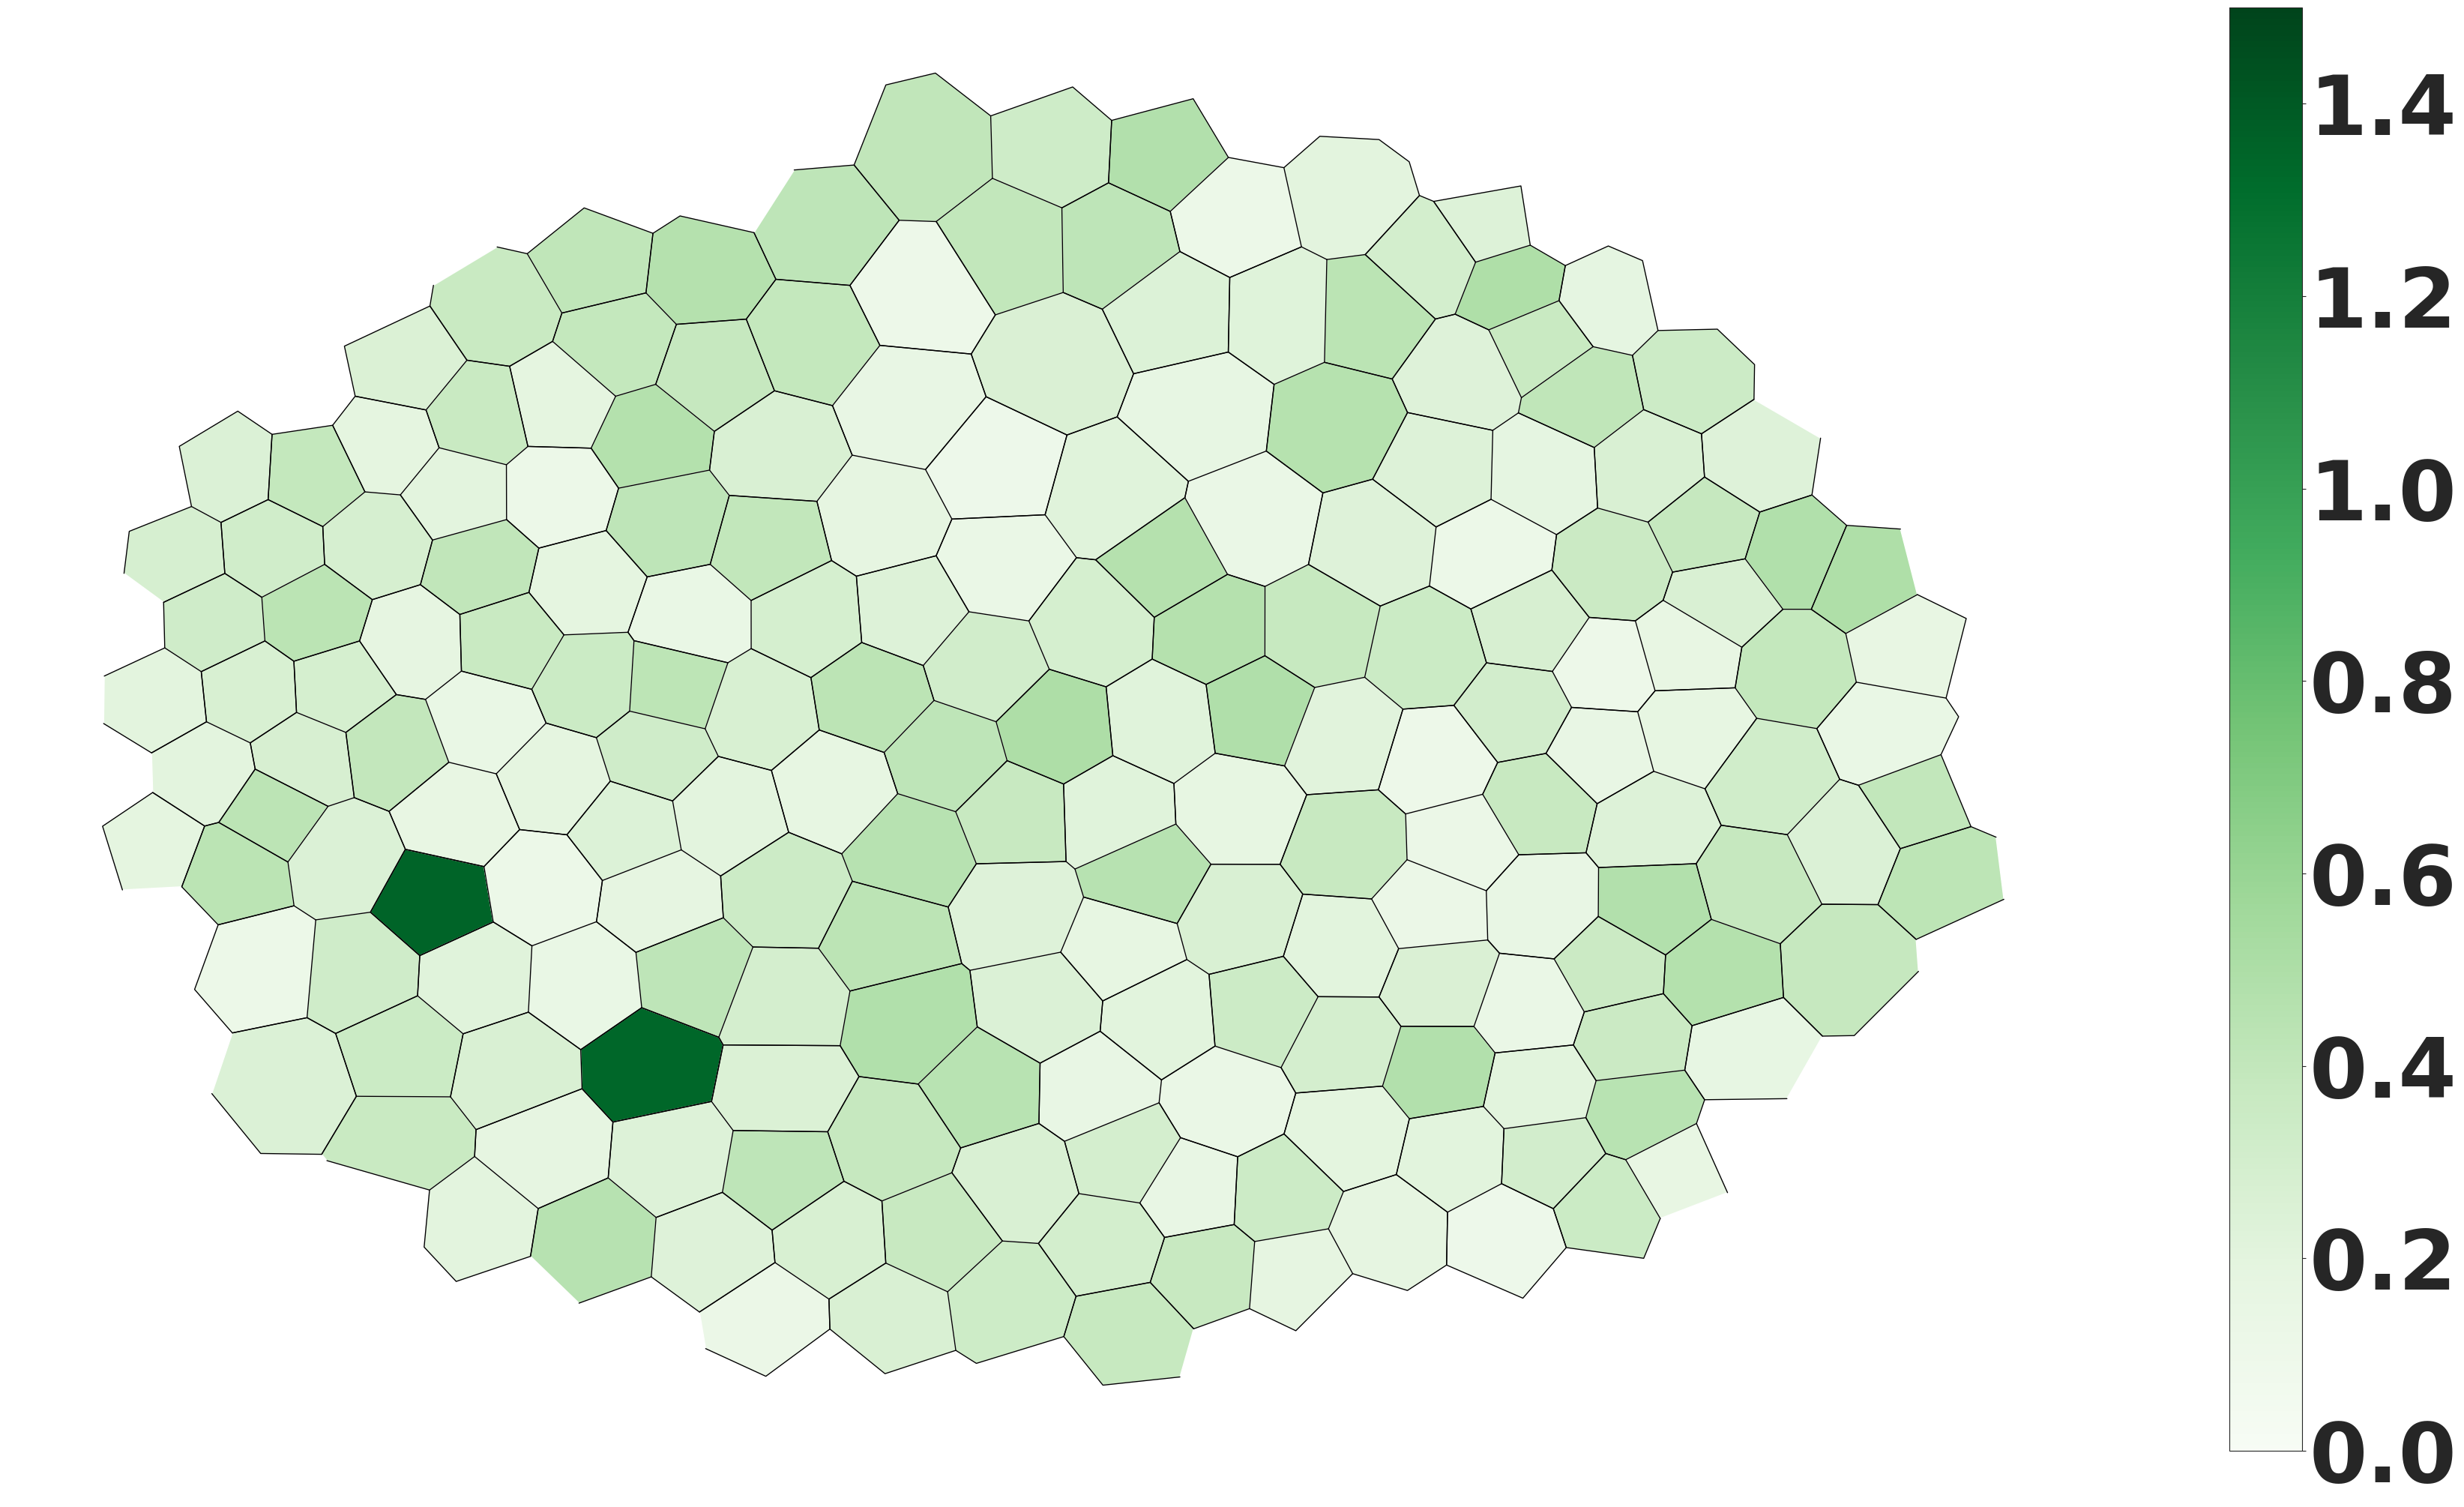

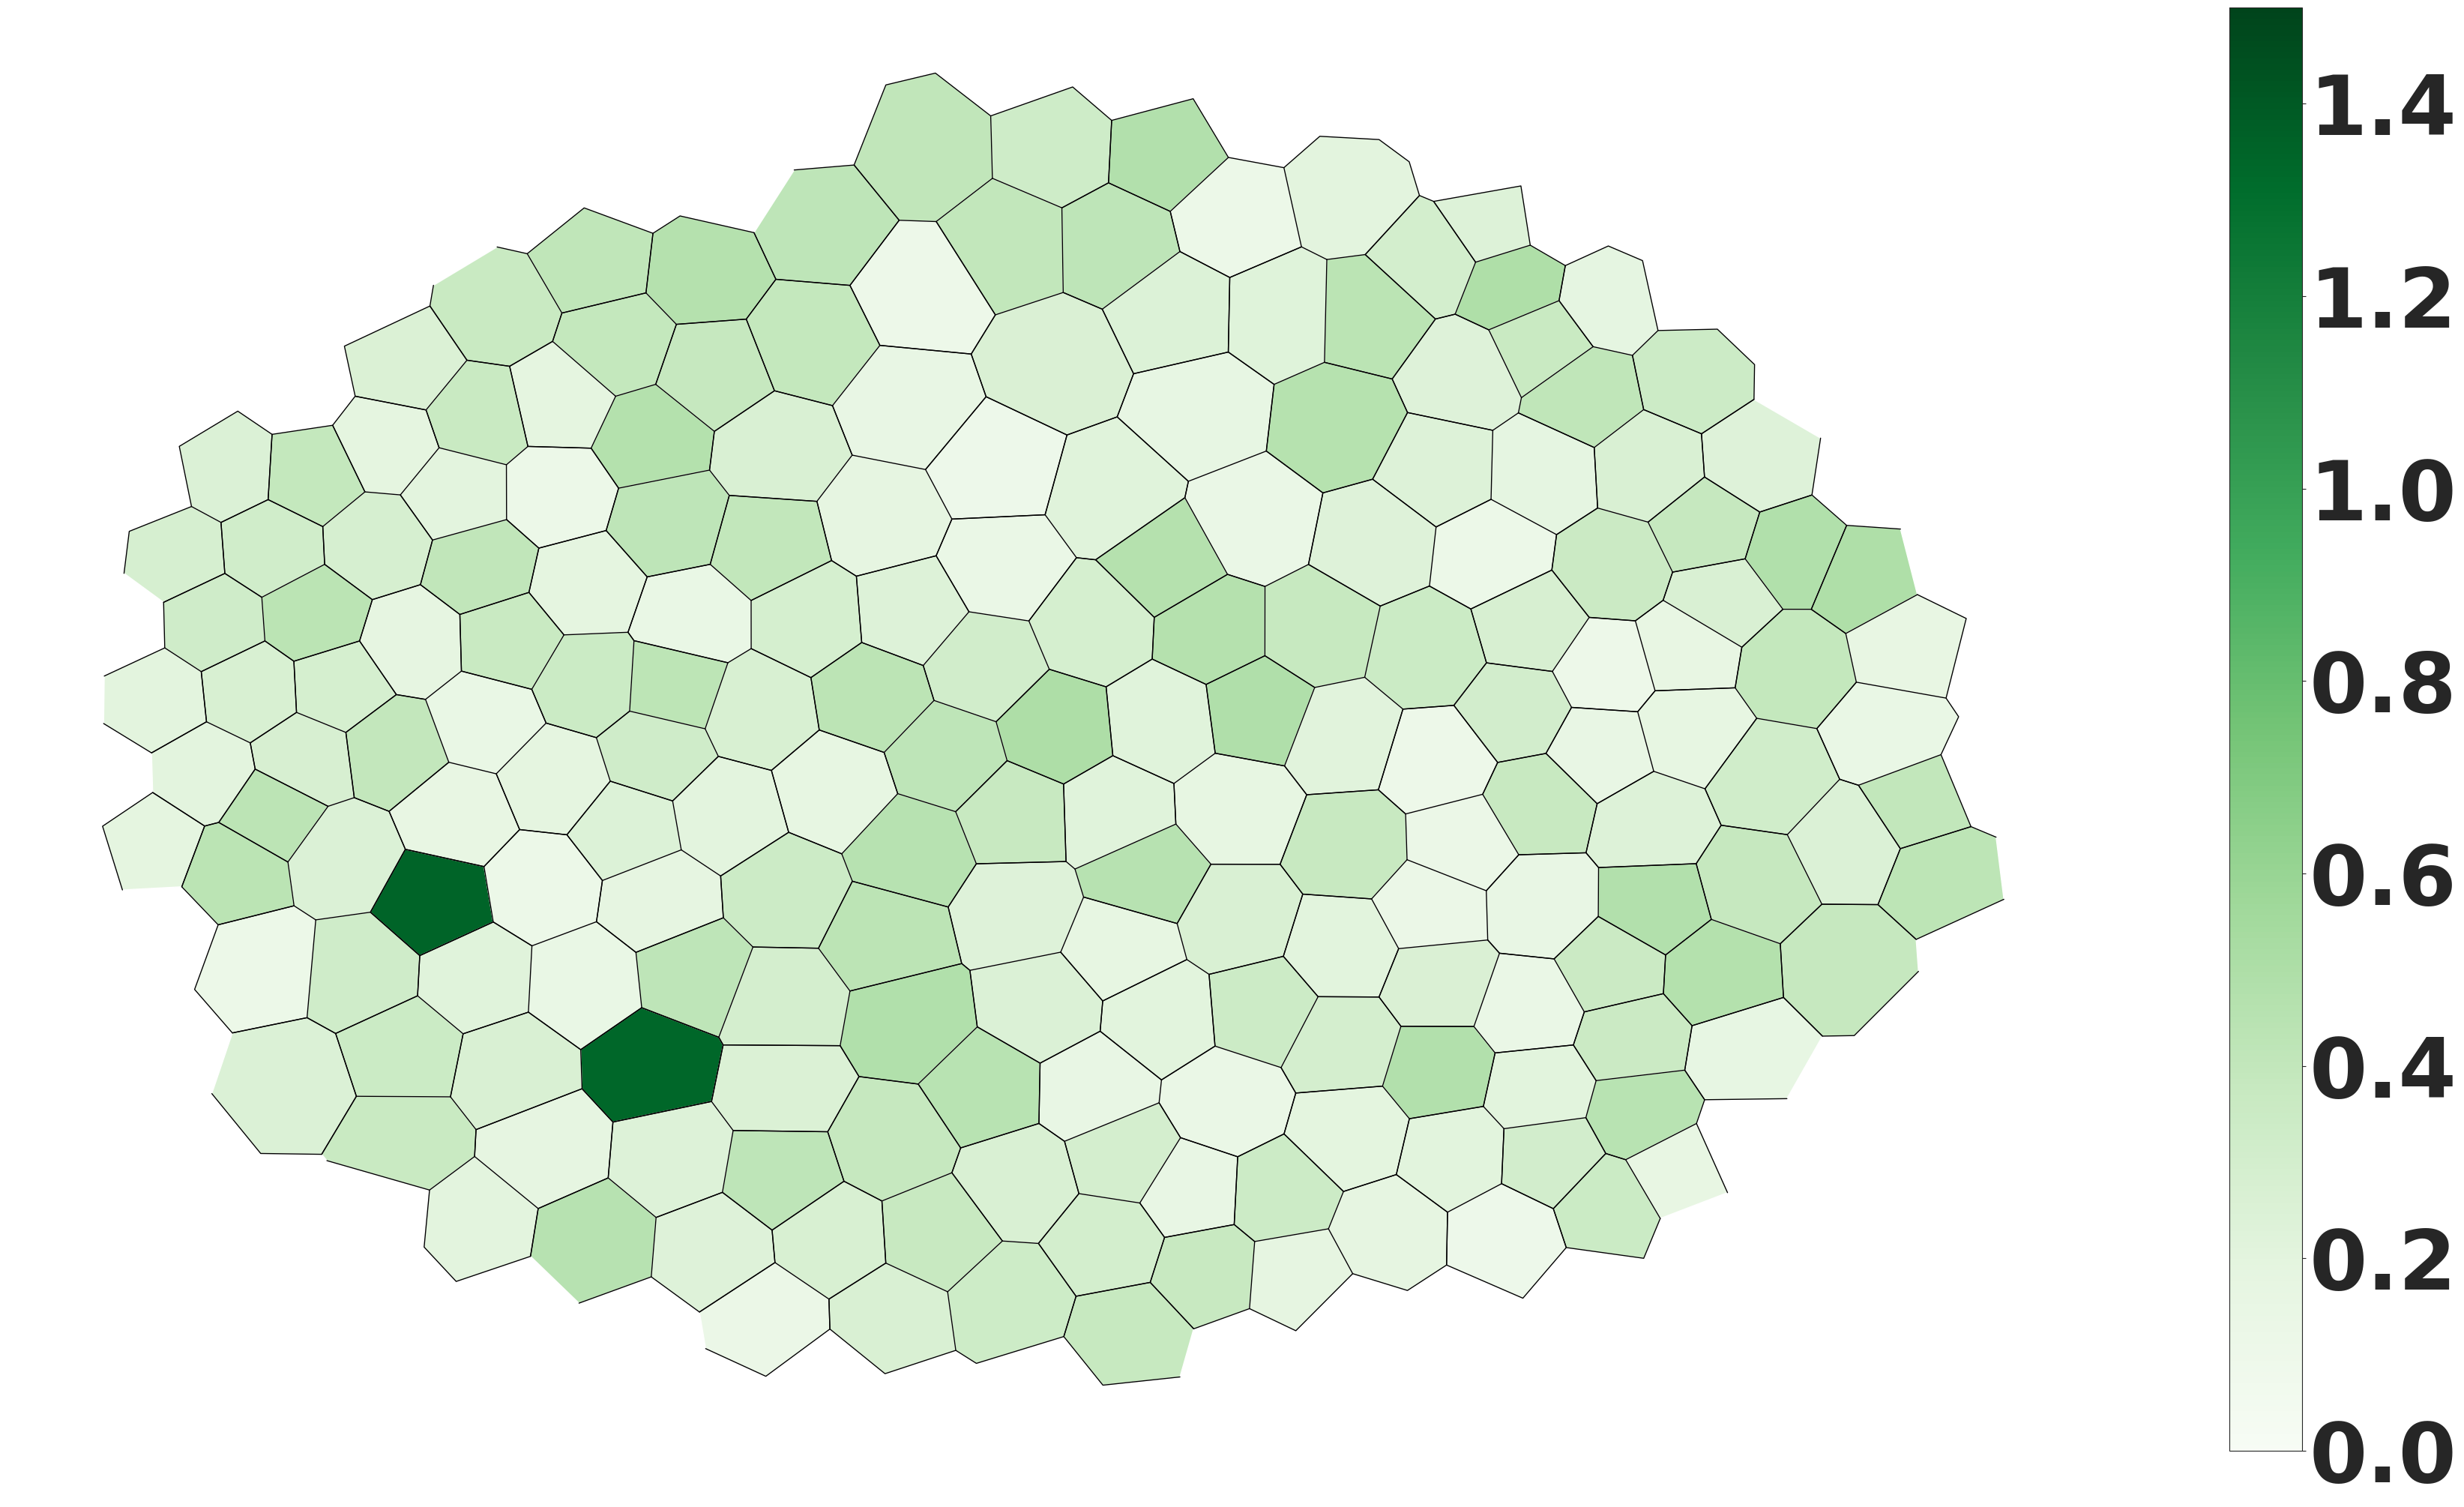

In [40]:
# # Do simulations withthe optogenetic stimulation
p_Spikes.draw_profile(saveFolderName)


p_Spikes_opt_dt.draw_profile(saveFolderName)


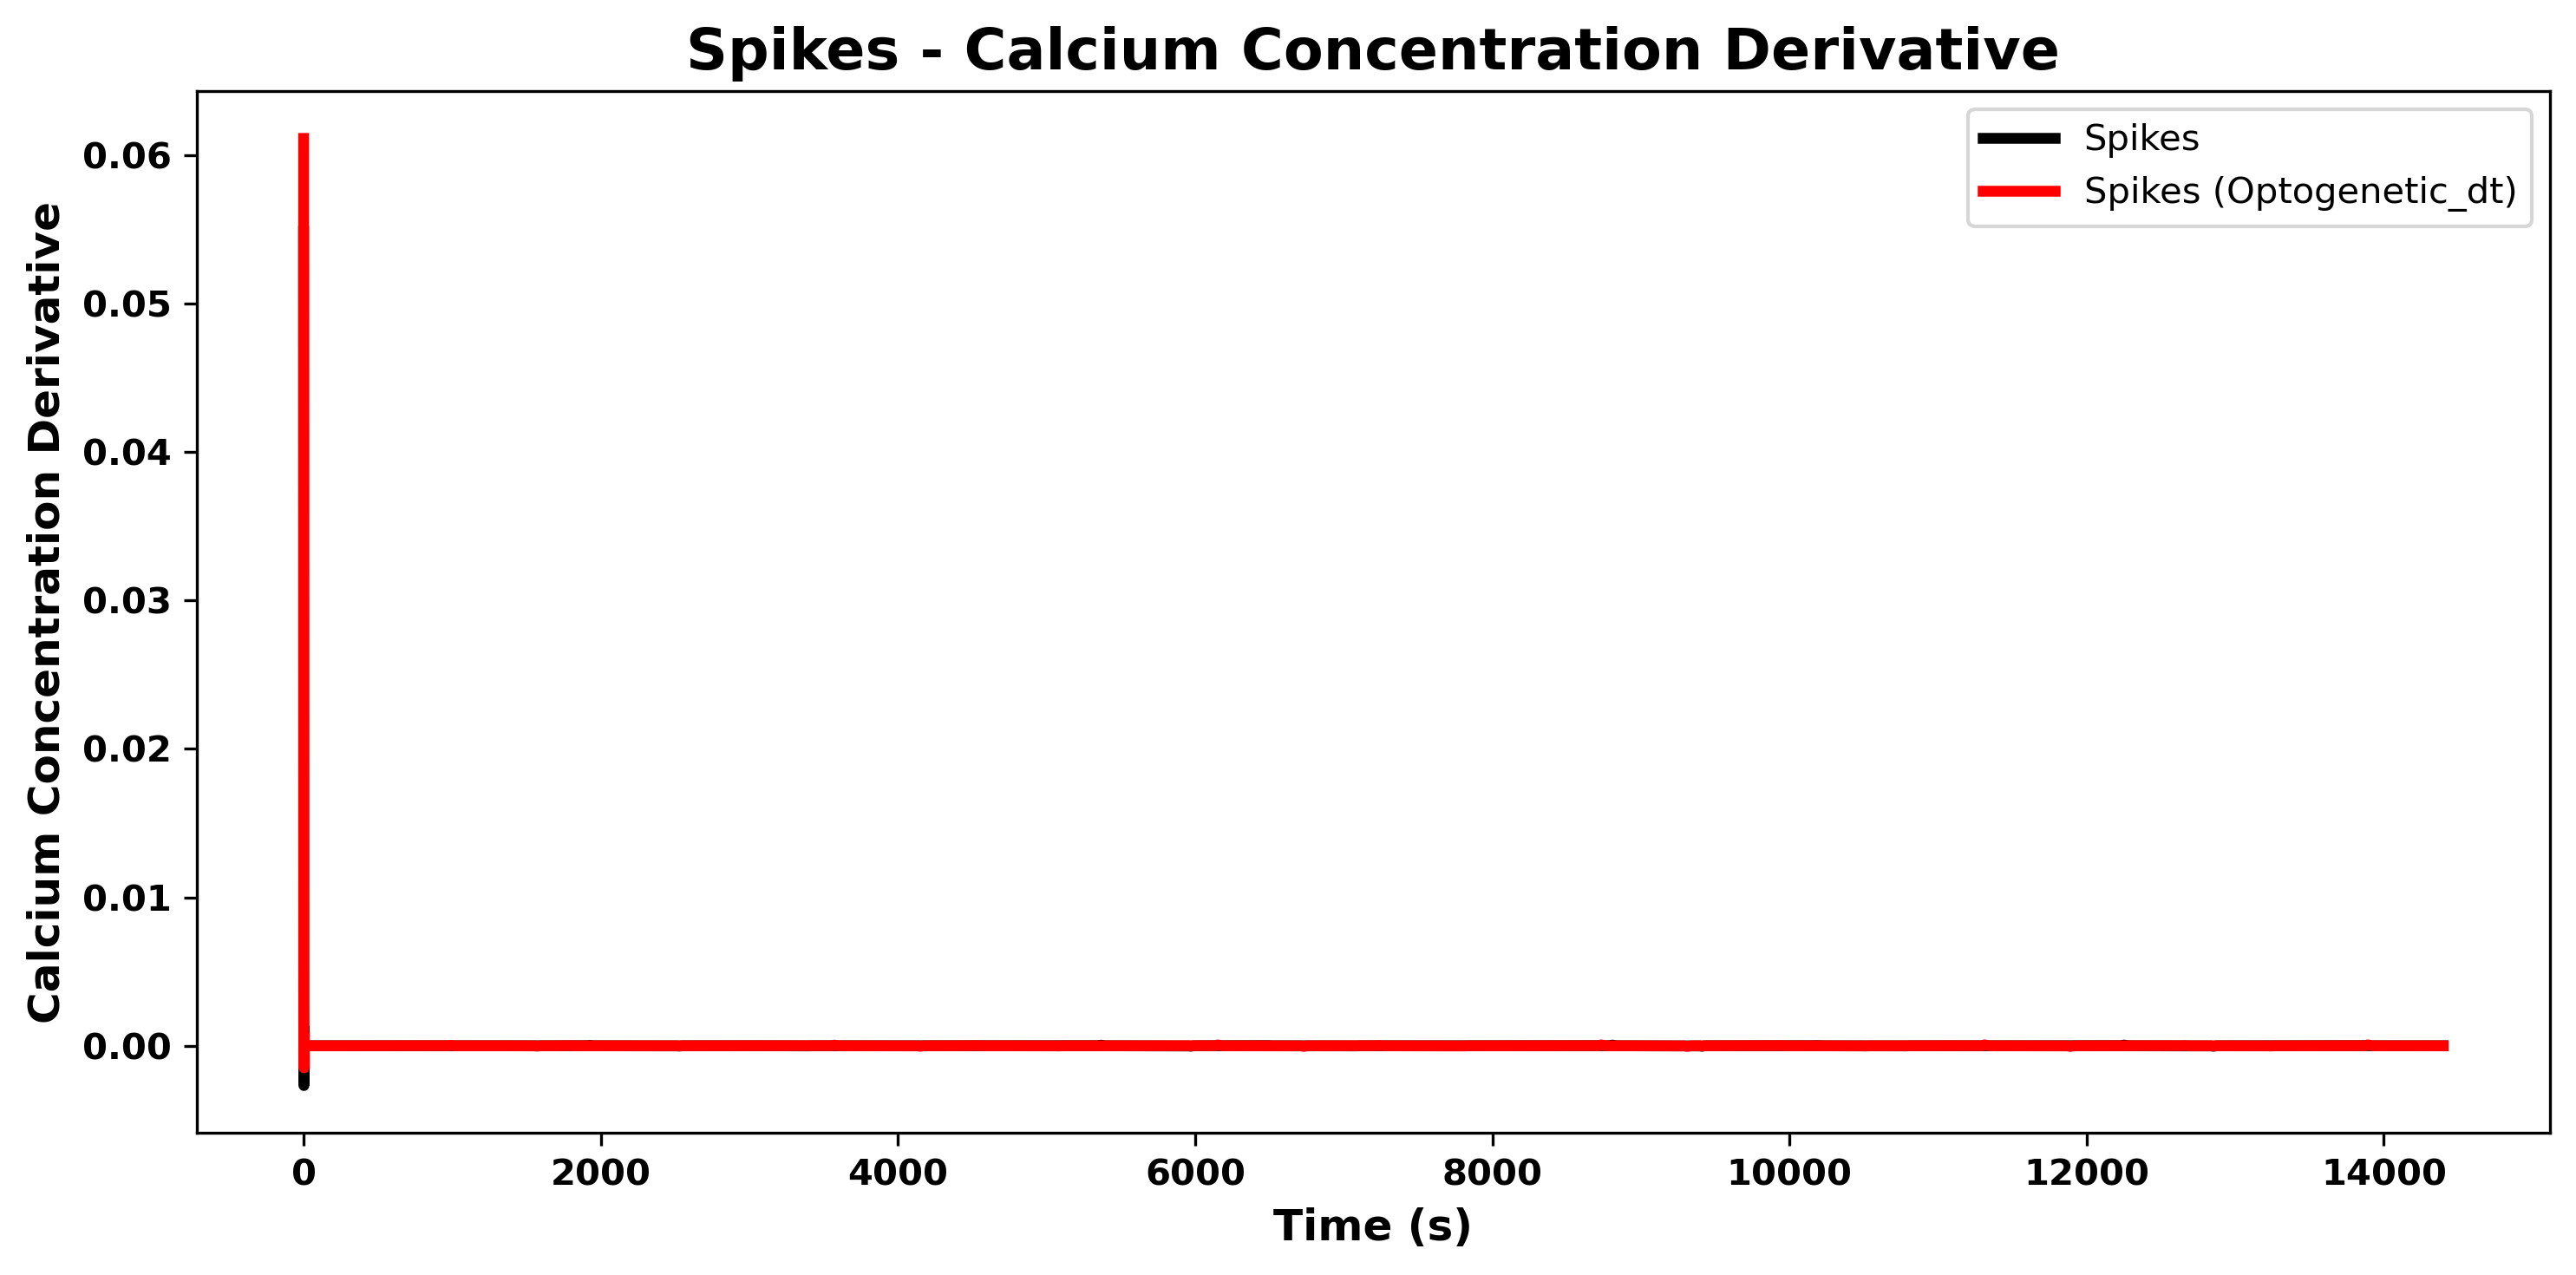

In [42]:
# Plot the derivative of the calcium dynamics for Spikes (normal and optogenetic_dt version)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

# Normal Spikes
ax.plot(np.diff(p_Spikes.disc_dynamics[20, 0, :].T), color='black', label='Spikes', linewidth=3)

# Optogenetic_dt Spikes
ax.plot(np.diff(p_Spikes_opt_dt.disc_dynamics[20, 0, :].T), color='red', label='Spikes (Optogenetic_dt)', linewidth=3)

ax.set_title('Spikes - Calcium Concentration Derivative', fontsize=16, fontweight='bold')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Calcium Concentration Derivative', fontsize=12, fontweight='bold')

# Make x and y ticks bold
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize(10)

ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path, 'Spikes_calcium_derivative.svg'), transparent=True)
plt.savefig(os.path.join(sim_folder_path, 'Spikes_calcium_derivative.png'), transparent=True)
plt.show()


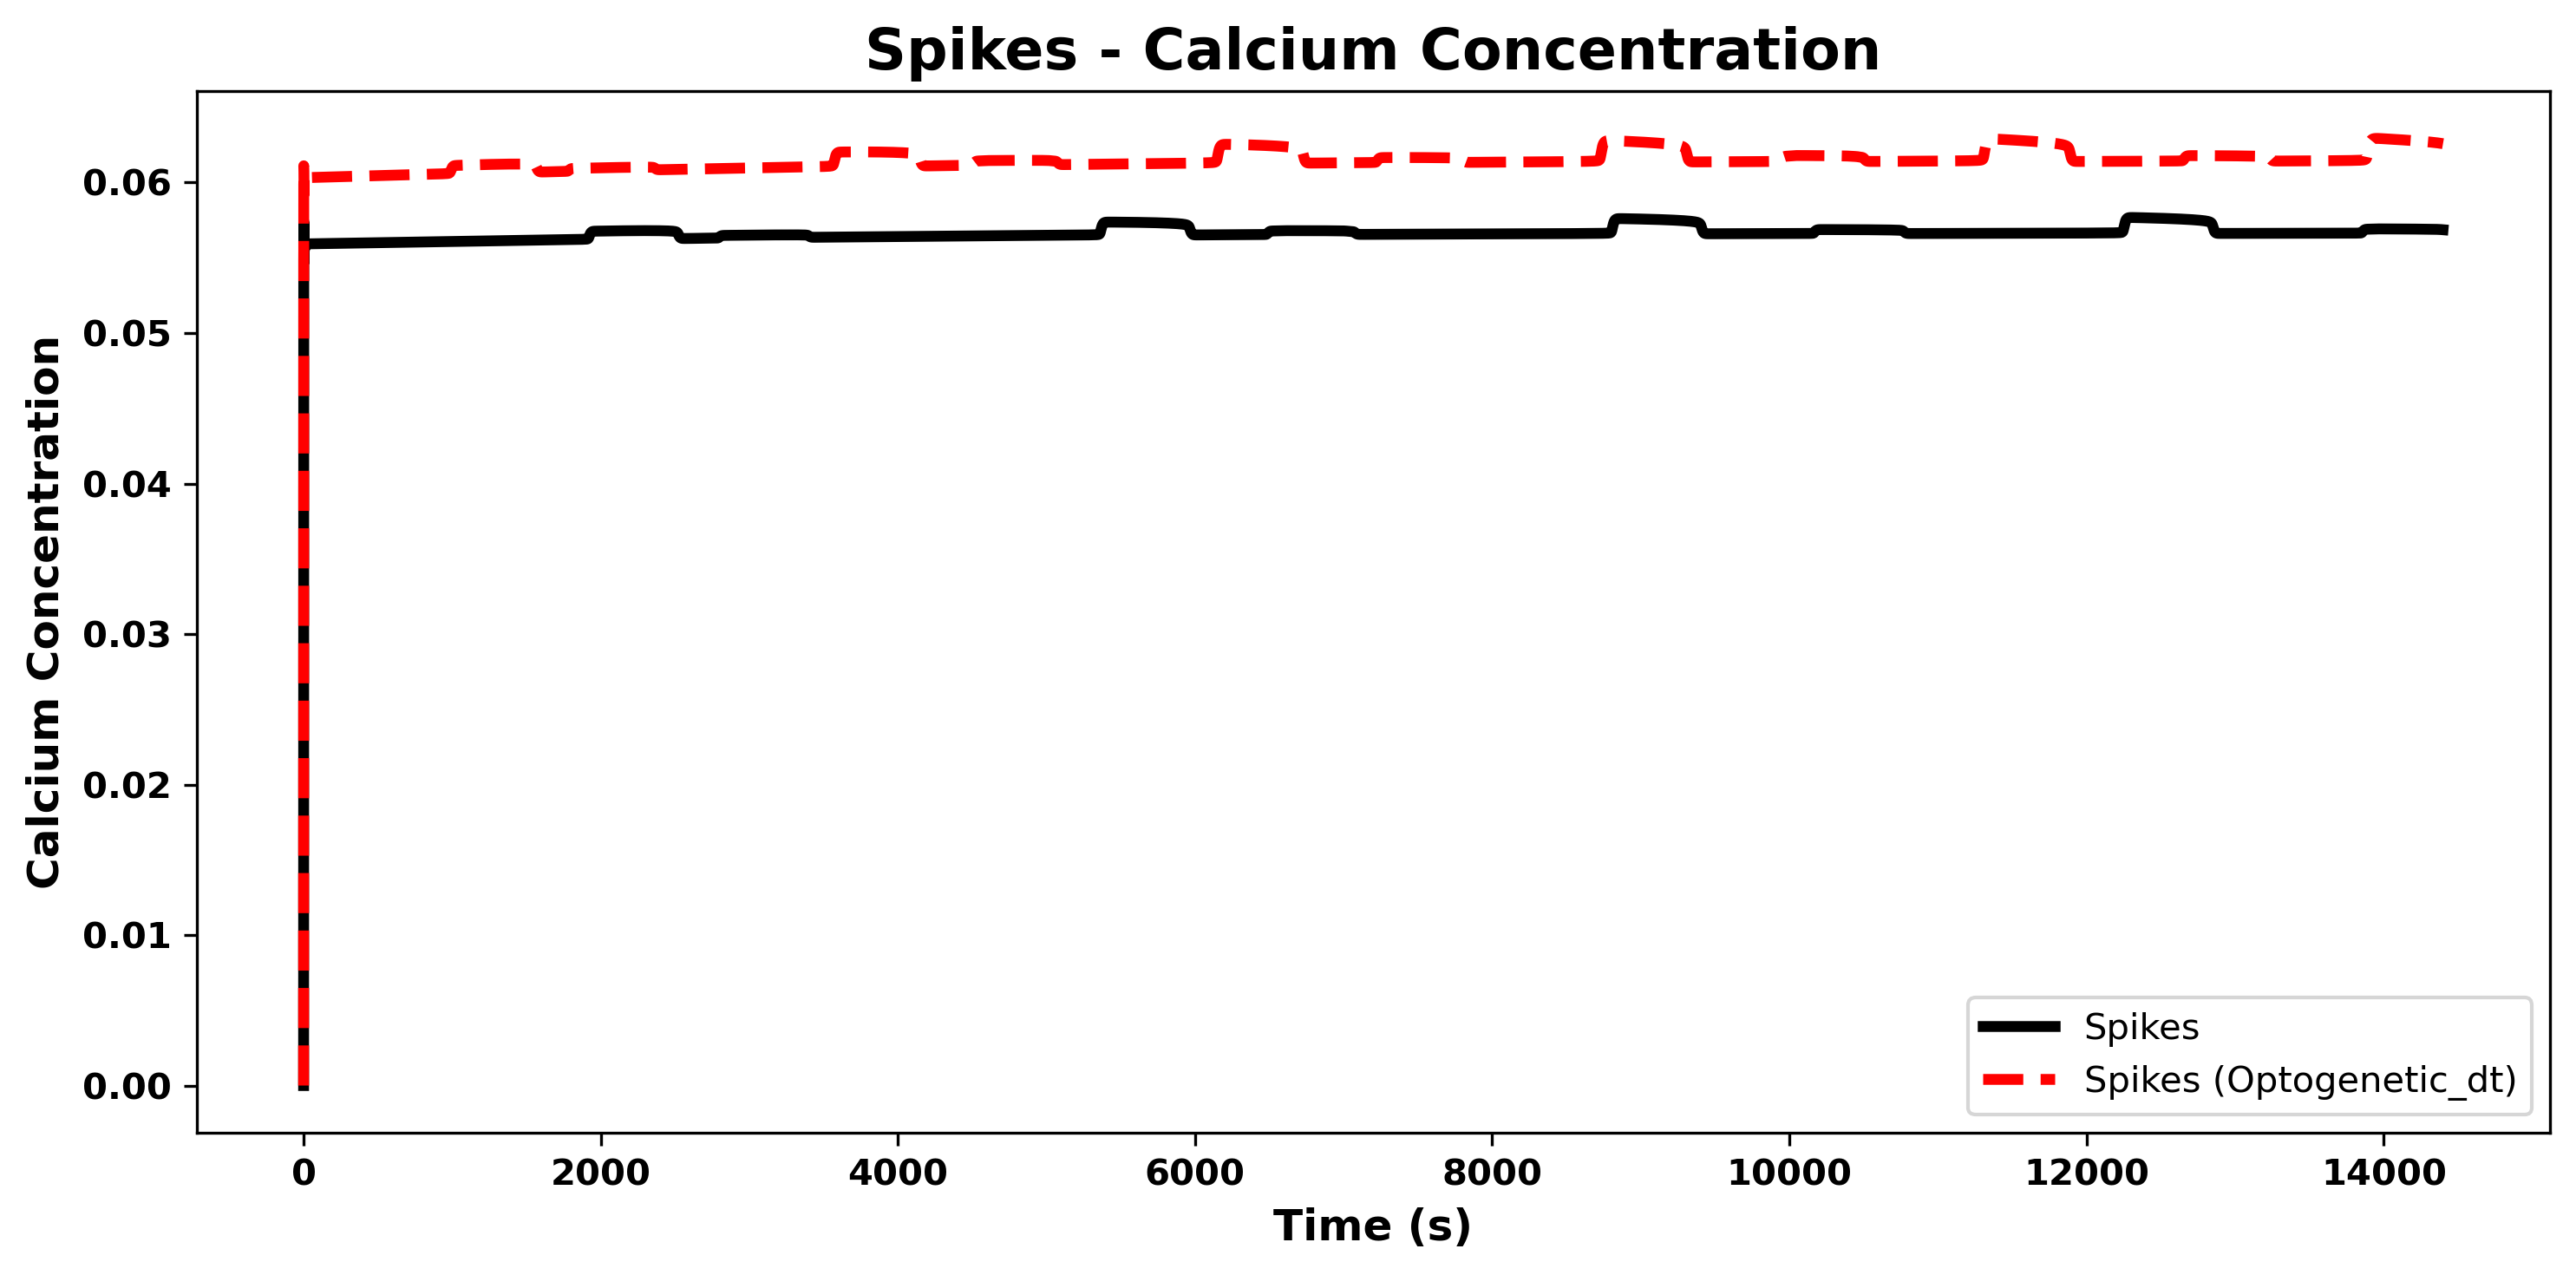

In [43]:
# Plot calcium dynamics for Spikes with and without optogenetic stimulation (dt version)
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Normal Spikes
ax.plot(p_Spikes.disc_dynamics[20, 0, :].T, color='black', label='Spikes', linewidth=3)

# Optogenetic_dt Spikes
ax.plot(p_Spikes_opt_dt.disc_dynamics[20, 0, :].T, color='red', linestyle='--', label='Spikes (Optogenetic_dt)', linewidth=3)

ax.set_title('Spikes - Calcium Concentration', fontsize=16, fontweight='bold')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Calcium Concentration', fontsize=12, fontweight='bold')

# Make x and y ticks bold
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize(10)

ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path, 'Spikes_calcium_dynamics.svg'), transparent=True)
plt.show()


# Simulate changing alpha and resulting values

In [44]:
# Simulate the calcium dynamics with varying alpha value for Spikes (optogenetic_dt version)
alpha_values = [0, 0.001, 0.005, 0.01, 0.05]
simulations = {'Spikes': []}

for alpha in alpha_values:
    # Spikes
    sim_params = sim_params_Spikes.copy()
    sim_params['alpha'] = alpha
    simulation = Pouch(params=sim_params, size='xsmall', sim_number=12345, save=True, saveName=f'Fig_2_Spikes_alpha_{alpha}_dt')
    simulation.simulate_optogenetic_dt()
    simulations['Spikes'].append(simulation)


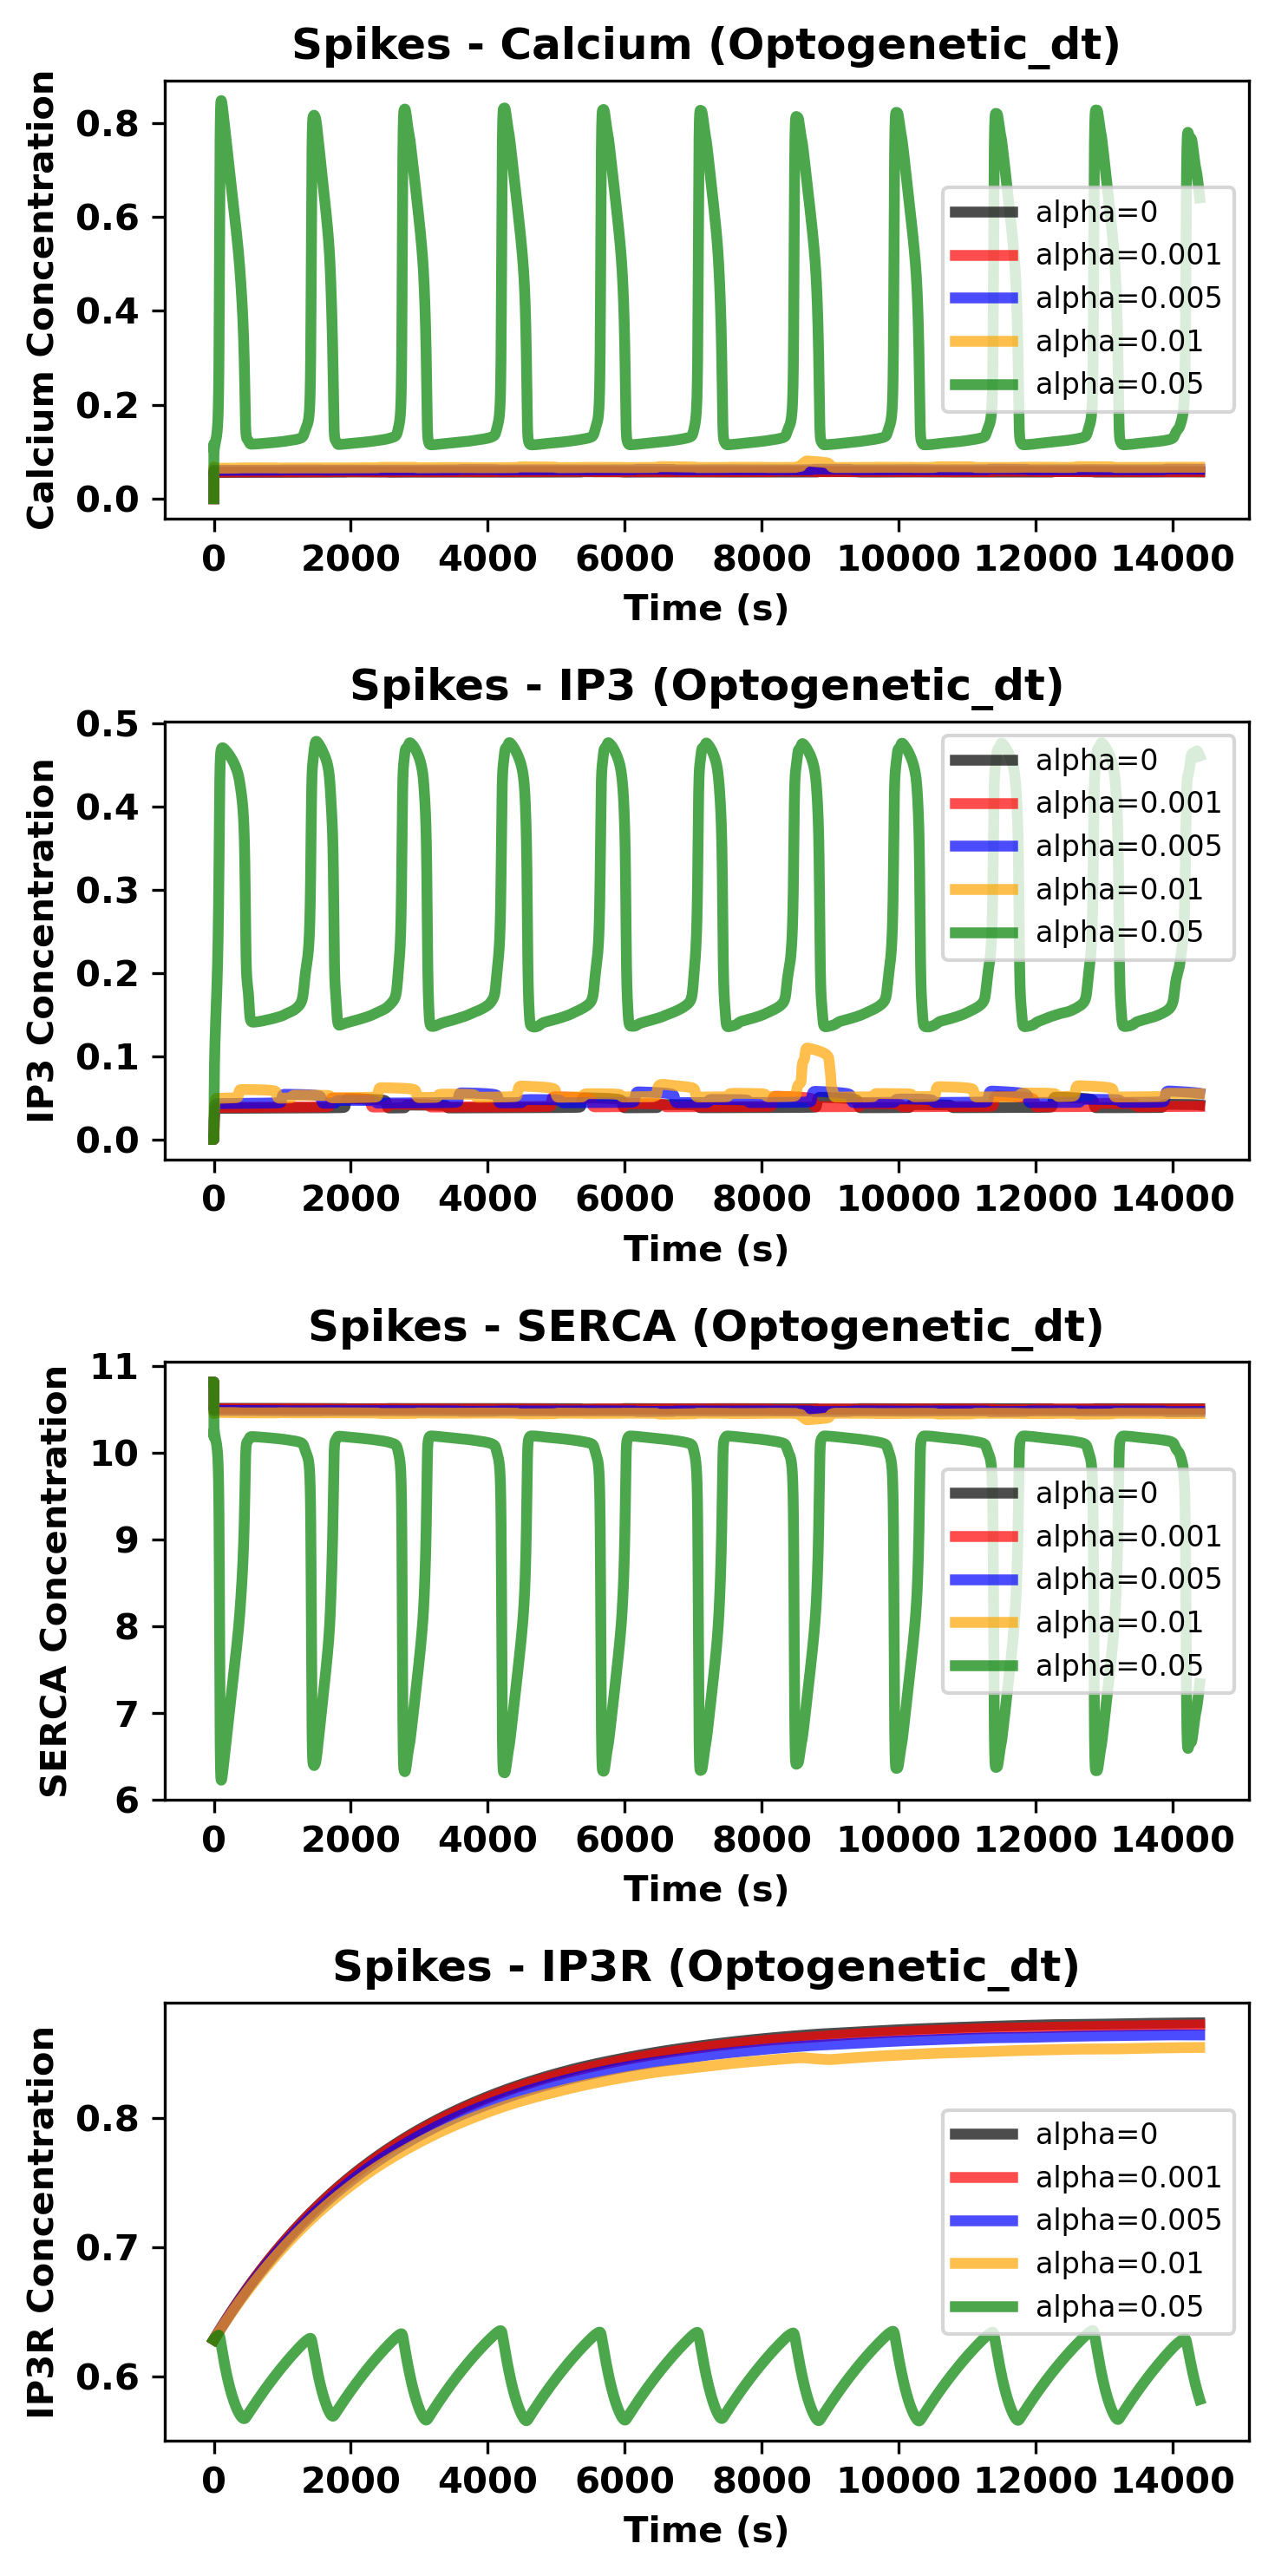

In [49]:
# Plot calcium, IP3, SERCA, and IP3R dynamics for different alpha values (optogenetic_dt version)
state_names = ['Spikes']
state_labels = ['Calcium', 'IP3', 'SERCA', 'IP3R']
cell_indices = [20]

for cell_index in cell_indices:
    fig, axes = plt.subplots(4, 1, figsize=(5, 10), dpi=300)  # Adjusted for a single column
    
    for row, label in enumerate(state_labels):
        ax = axes[row]  # Get the current axis
        
        for i, alpha in enumerate(alpha_values):
            dynamics = simulations['Spikes'][i].disc_dynamics[cell_index, row, :]
            custom_colors = ['black', 'red', 'blue', 'orange', 'green']  # Define custom color list
            color = custom_colors[i % len(custom_colors)]  # Cycle through colors if more alpha values than colors
            ax.plot(dynamics, label=f'alpha={alpha}', alpha=0.7, color=color, linewidth=3)

        ax.set_title(f'Spikes - {label} (Optogenetic_dt)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=10, fontweight='bold')  # Bold X-axis label
        ax.set_ylabel(f'{label} Concentration', fontsize=10, fontweight='bold')  # Bold Y-axis label

        # Make x and y ticks bold
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(10)

        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.png'), transparent=True)
    plt.show()


# Output the simulation videos

In [14]:
# p_Spikes.make_animation(saveFolderName)
# p_Spikes_opt_dt.make_animation(saveFolderName)




# Now without gap junctions

## simulate_optogenetic_dt

In [15]:
# Simulate the calcium dynamics with varying alpha value for Spikes (optogenetic_dt no_gap version)
alpha_values = [0, 0.001, 0.005, 0.01, 0.05]
simulations_dt_no_gap = {'Spikes': []}

for alpha in alpha_values:
    # Spikes
    sim_params = sim_params_Spikes.copy()
    sim_params['alpha'] = alpha
    sim_params['D_p'] = 0
    sim_params['D_c_ratio'] = 0
    simulation = Pouch(params=sim_params, size='xsmall', sim_number=12345, save=True, saveName=f'Fig_2_Spikes_alpha_{alpha}_dt_no_gap')
    simulation.simulate_optogenetic_dt()
    simulations_dt_no_gap['Spikes'].append(simulation)


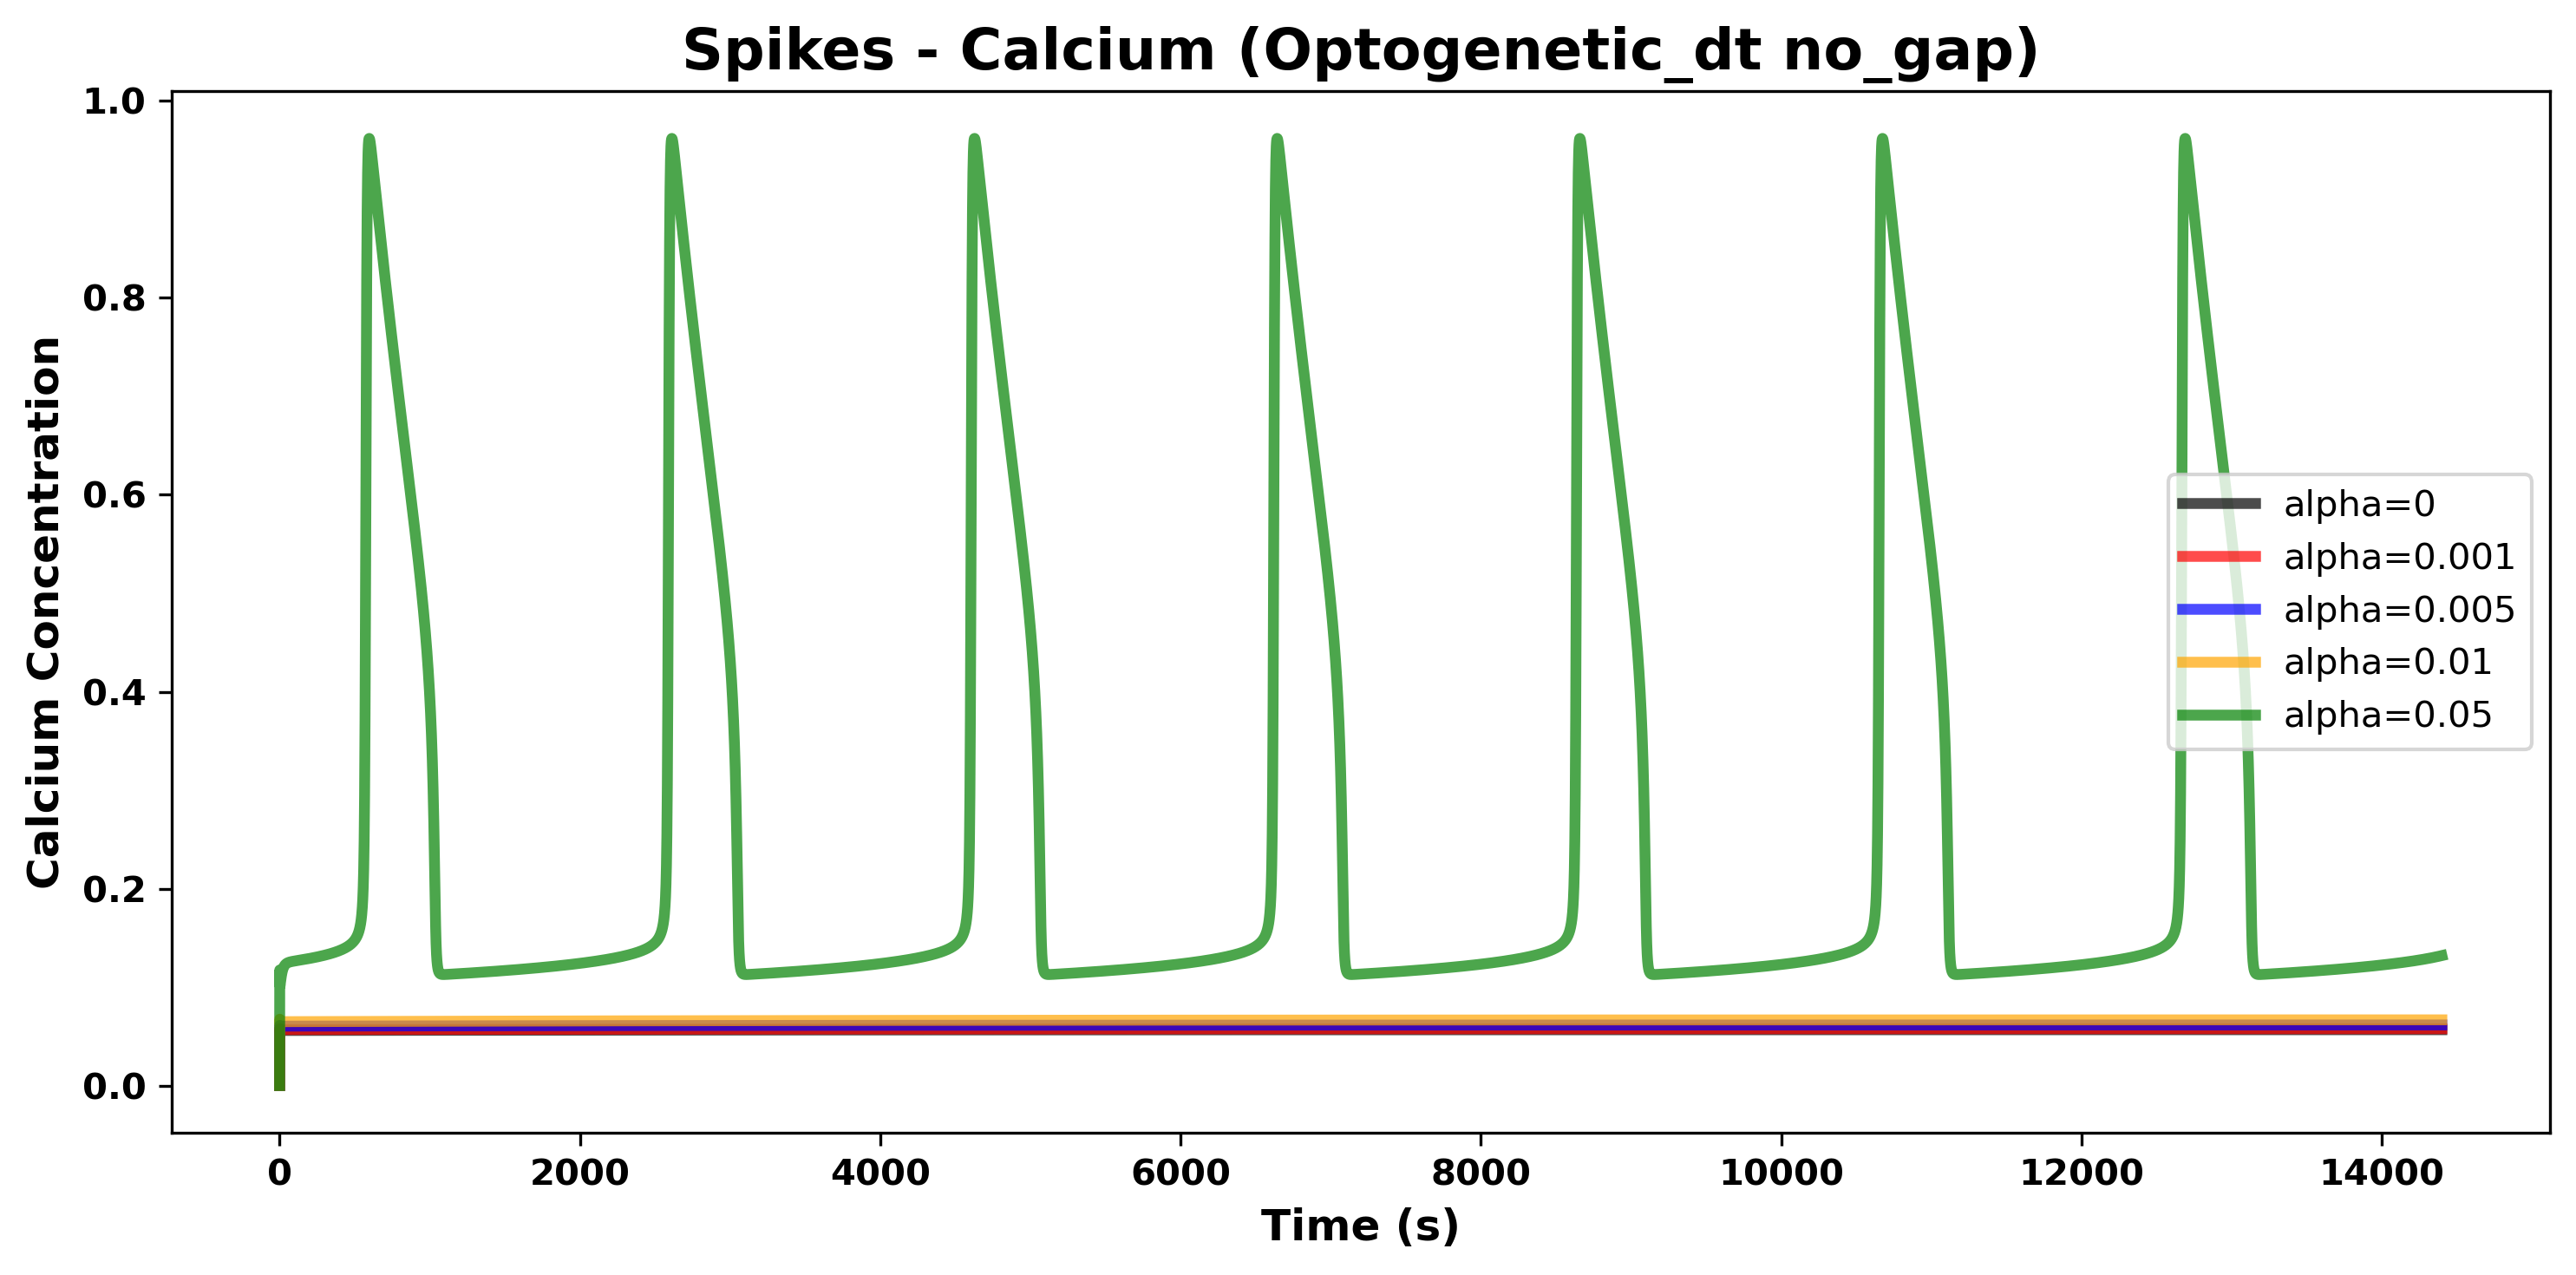

In [51]:
# Plot calcium dynamics for different alpha values (optogenetic_dt no_gap version)
state_names = ['Spikes']
state_labels = ['Calcium']
cell_indices = [20]

# Define custom color list
custom_colors = ['black', 'red', 'blue', 'orange', 'green']

for cell_index in cell_indices:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)  # Adjusted for a single row

    for col, state in enumerate(state_names):
        for i, alpha in enumerate(alpha_values):
            dynamics = simulations_dt_no_gap[state][i].disc_dynamics[cell_index, 0, :]  # Only plot Calcium
            color = custom_colors[i % len(custom_colors)]  # Cycle through colors if more alpha values than colors
            ax.plot(dynamics, label=f'alpha={alpha}', alpha=0.7, color=color, linewidth=3)
        ax.set_title(f'{state} - Calcium (Optogenetic_dt no_gap)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Calcium Concentration', fontsize=12, fontweight='bold')

        # Make x and y ticks bold
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontweight('bold')
            label.set_fontsize(10)

        ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_calcium_dynamics_no_gap.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_calcium_dynamics_no_gap.png'), transparent=True)
    plt.show()

In [52]:
def count_initiator_cells(sim_gap, sim_no_gap, threshold=0.5):
    """
    Count the number of initiator cells that spike in both the gap and no-gap versions of a simulation.

    Parameters:
        sim_gap: Pouch object for the gap version of the simulation.
        sim_no_gap: Pouch object for the no-gap version of the simulation.
        threshold: float, the calcium concentration threshold for spiking.

    Returns:
        int: The number of initiator cells that spike in both versions.
    """
    # Identify cells that spike in the gap version
    spiking_cells_gap = set(np.where(np.max(sim_gap.disc_dynamics[:, 0, :], axis=1) > threshold)[0])
    
    # Identify cells that spike in the no-gap version
    spiking_cells_no_gap = set(np.where(np.max(sim_no_gap.disc_dynamics[:, 0, :], axis=1) > threshold)[0])
    
    # Find the intersection of the two sets
    common_spiking_cells = spiking_cells_gap.intersection(spiking_cells_no_gap)
    
    return len(common_spiking_cells)

# Example usage for the "Spikes" simulation
num_initiator_cells_spikes = count_initiator_cells(simulations_dt_no_gap['Spikes'][3], simulations_dt_no_gap['Spikes'][3])
print(f"Number of initiator cells for 'Spikes': {num_initiator_cells_spikes}")



Number of initiator cells for 'Spikes': 2


In [ ]:
# Define alpha values to vary from 10^-4 to 0.5
alpha_values = np.logspace(-4, -0.3, 100)  # Logarithmic spacing for better resolution

# Define a parameter set that can be modified
modifiable_params = {
    'threshold': 0.5,  # Calcium concentration threshold for spiking
    'size': 'xsmall',  # Size of the pouch
    'sim_number': 12345,  # Simulation number for reproducibility
    'save': True,  # Whether to save the results
    'save_folder': saveFolderName  # Folder to save results
}

# Function to compute initiator fractions
def compute_initiator_fractions(simulations, simulations_no_gap, alpha_values, state_names, params):
    results = {state: {'gap': [], 'no_gap': [], 'both': []} for state in state_names}
    for state in state_names:
        for i, alpha in enumerate(alpha_values):
            print(f"Processing state: {state}, alpha: {alpha:.4f} ({i+1}/{len(alpha_values)})")
            sim_gap = simulations[state][i]
            sim_no_gap = simulations_no_gap[state][i]
            
            # Identify spiking cells in gap and no-gap simulations
            spiking_cells_gap = set(np.where(np.max(sim_gap.disc_dynamics[:, 0, :], axis=1) > params['threshold'])[0])
            spiking_cells_no_gap = set(np.where(np.max(sim_no_gap.disc_dynamics[:, 0, :], axis=1) > params['threshold'])[0])
            
            # Compute fractions
            total_cells = sim_gap.n_cells
            gap_fraction = len(spiking_cells_gap) / total_cells
            no_gap_fraction = len(spiking_cells_no_gap) / total_cells
            both_fraction = len(spiking_cells_gap.intersection(spiking_cells_no_gap)) / total_cells
            
            # Store results
            results[state]['gap'].append(gap_fraction)
            results[state]['no_gap'].append(no_gap_fraction)
            results[state]['both'].append(both_fraction)
    return results

# Run simulations for varying alpha values
state_names = ['Spikes']
simulations = {state: [] for state in state_names}
simulations_no_gap = {state: [] for state in state_names}

for alpha in alpha_values:
    for state in state_names:
        # Gap simulations
        sim_params_gap = sim_params_Spikes.copy()
        sim_params_gap['alpha'] = alpha
        sim_gap = Pouch(params=sim_params_gap, size=modifiable_params['size'], sim_number=modifiable_params['sim_number'], save=modifiable_params['save'], saveName=f'{state}_alpha_{alpha:.4f}')
        sim_gap.simulate_optogenetic_dt()
        simulations[state].append(sim_gap)
        
        # No-gap simulations
        sim_params_no_gap = sim_params_Spikes.copy()
        sim_params_no_gap['alpha'] = alpha
        sim_params_no_gap['D_p'] = 0
        sim_params_no_gap['D_c_ratio'] = 0
        sim_no_gap = Pouch(params=sim_params_no_gap, size=modifiable_params['size'], sim_number=modifiable_params['sim_number'], save=modifiable_params['save'], saveName=f'{state}_alpha_{alpha:.4f}_no_gap')
        sim_no_gap.simulate_optogenetic_dt()
        simulations_no_gap[state].append(sim_no_gap)

# Compute initiator fractions for all states
initiator_fractions = compute_initiator_fractions(simulations, simulations_no_gap, alpha_values, state_names, modifiable_params)


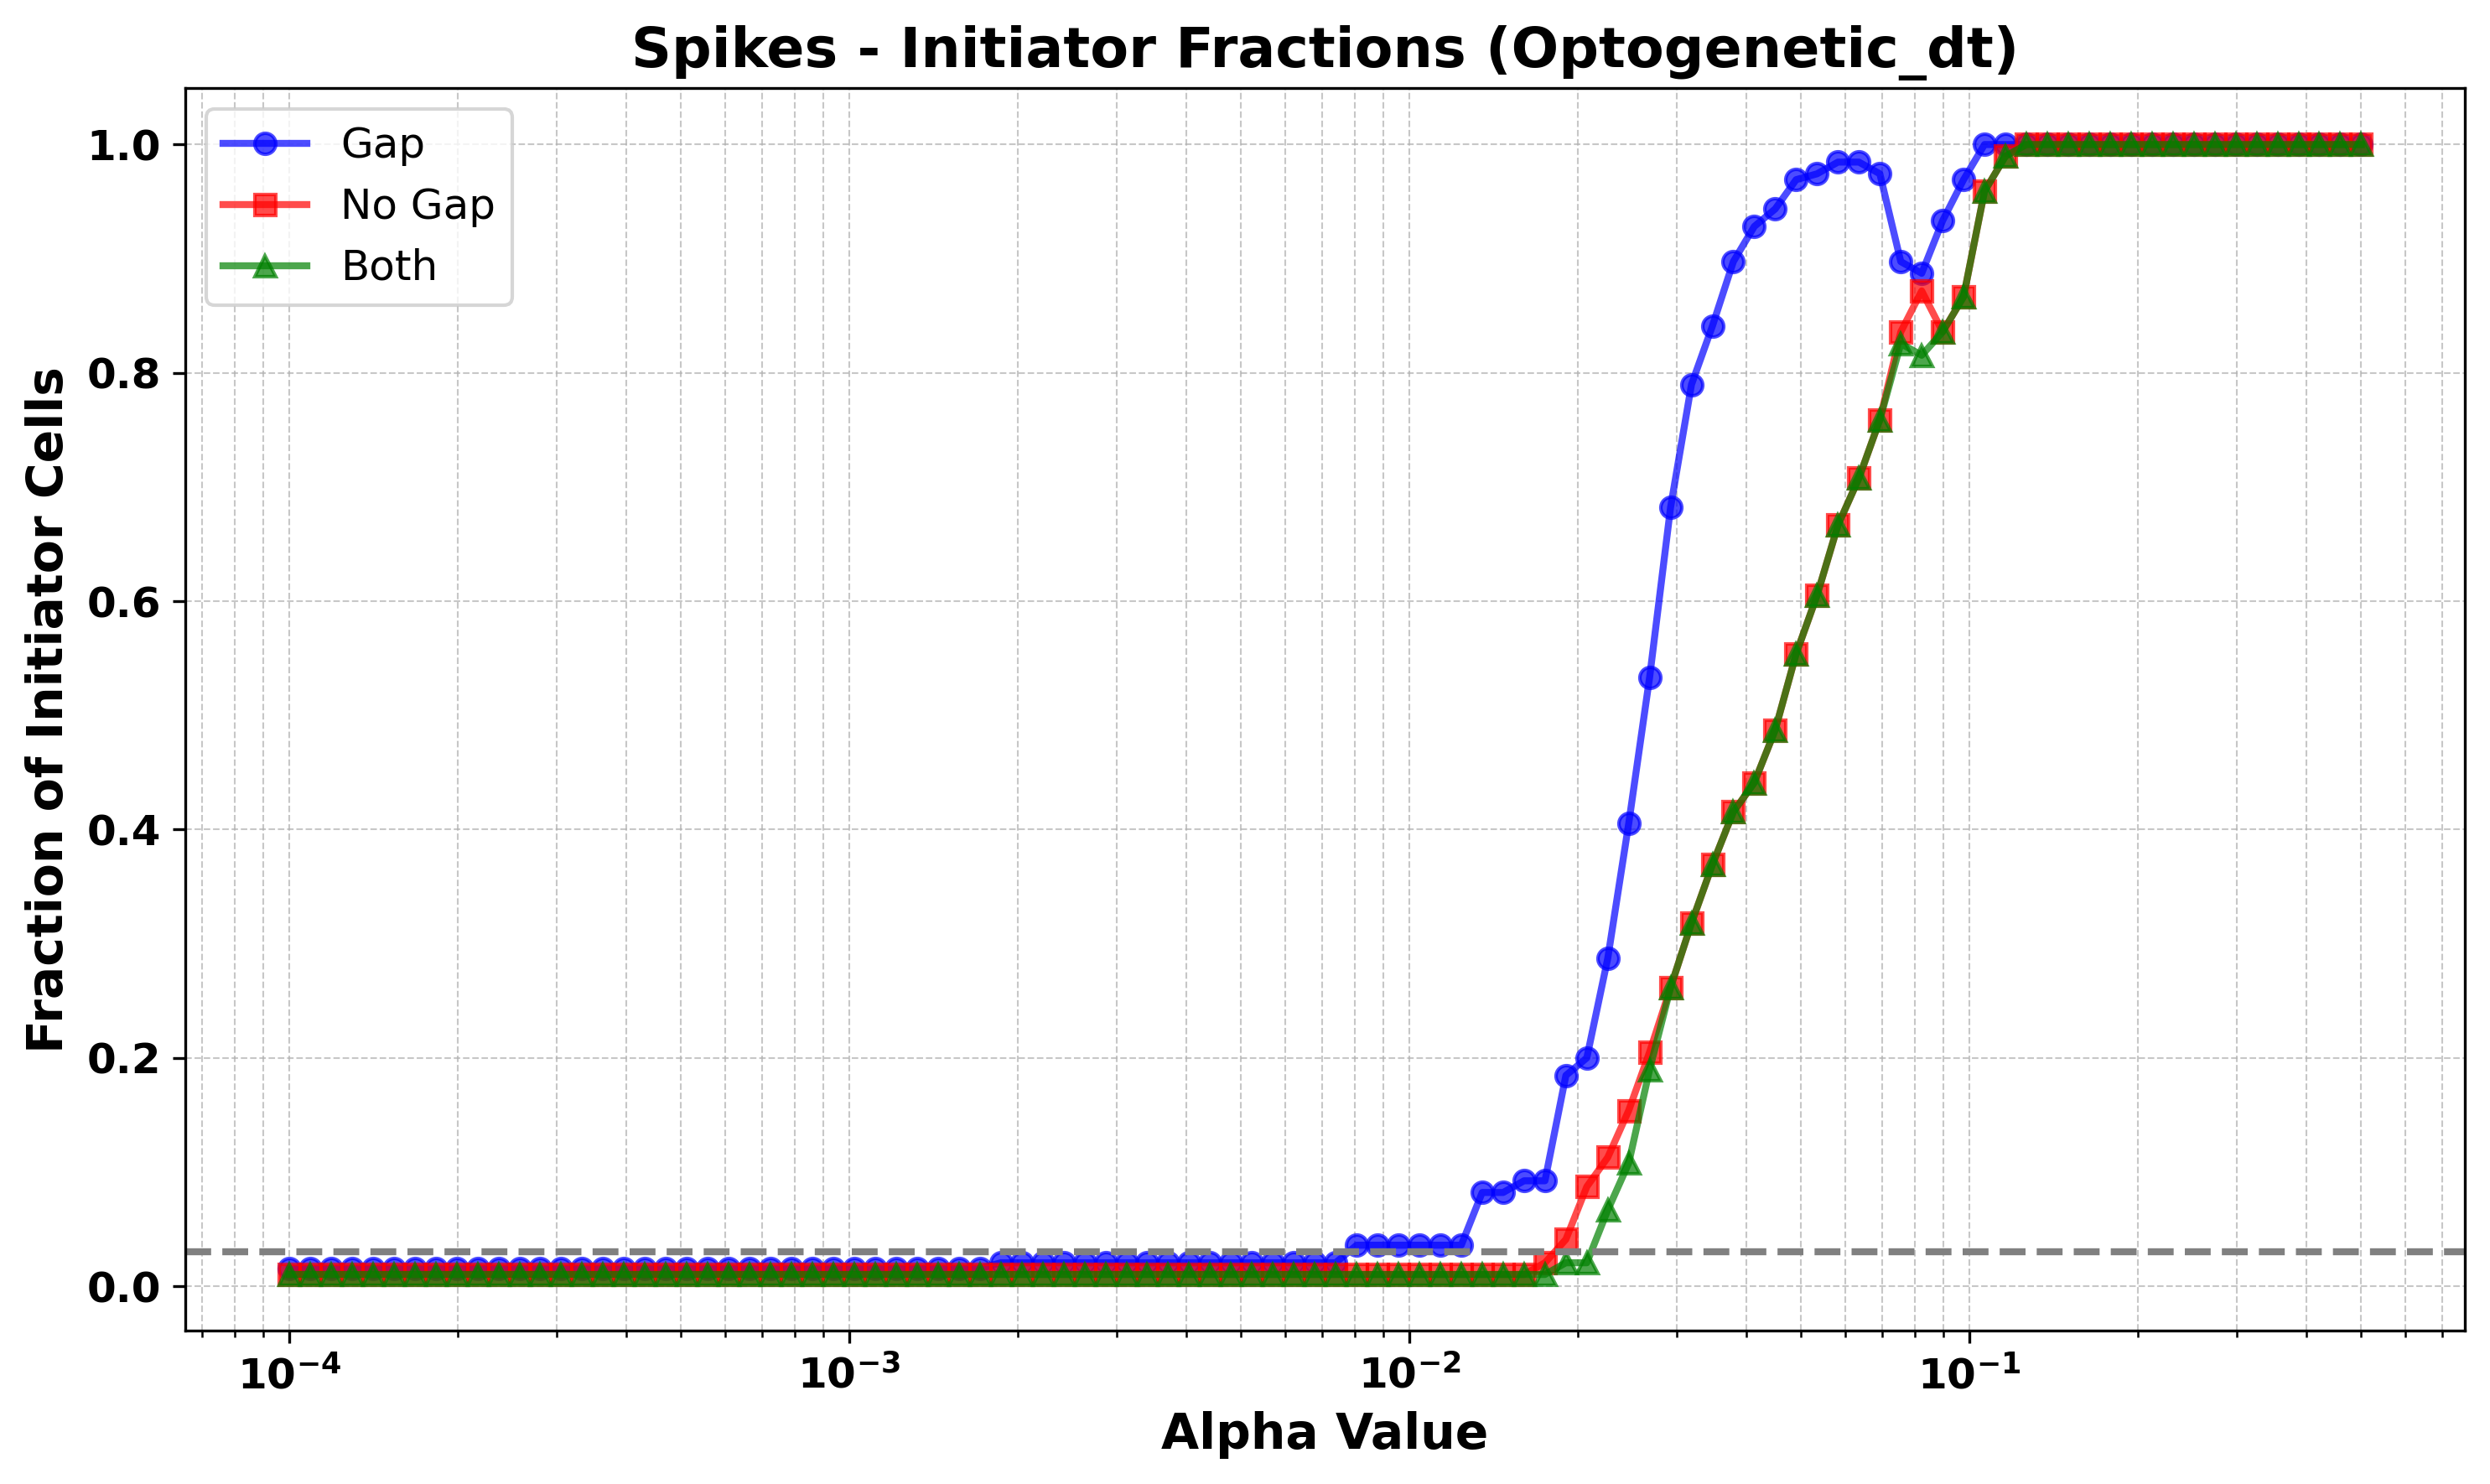

In [61]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Define a consistent color order
colors = ['blue', 'red', 'green']

# Plotting with specified colors, markers, and increased linewidth
ax.plot(alpha_values, initiator_fractions['Spikes']['gap'], label='Gap', color=colors[0], marker='o', alpha=0.7, linewidth=2, markersize=6)
ax.plot(alpha_values, initiator_fractions['Spikes']['no_gap'], label='No Gap', color=colors[1], marker='s', alpha=0.7, linewidth=2, markersize=6)
ax.plot(alpha_values, initiator_fractions['Spikes']['both'], label='Both', color=colors[2], marker='^', alpha=0.7, linewidth=2, markersize=6)

ax.set_xscale('log')
ax.set_title('Spikes - Initiator Fractions (Optogenetic_dt)', fontsize=16, fontweight='bold')
ax.set_xlabel('Alpha Value', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Initiator Cells', fontsize=14, fontweight='bold')

# Make x and y ticks bold with larger fontsize
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize(12)

ax.legend(fontsize=12)
ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()

val = 0.03  # draw a horizontal line at 0.03
# draw a horizontal line at 0.025
ax.axhline(y=val, color='gray', linestyle='--', label='10/195', linewidth=2)

# Save the figure with transparent background
# plt.savefig(os.path.join(sim_folder_path, 'Spikes_initiator_fractions.svg'), transparent=True)
# plt.savefig(os.path.join(sim_folder_path, 'Spikes_initiator_fractions.png'), transparent=True)

plt.show()


In [69]:
# Update simulation parameters for alpha = 0.01
sim_params_alpha_001 = sim_params_Spikes.copy()
sim_params_alpha_001['alpha'] = 0.01

# Create a Pouch object for the simulation
p_Spikes_alpha_001 = Pouch(params=sim_params_alpha_001, size='xsmall', sim_number=12345, save=True, saveName='Spikes_alpha_001_dt')

# Simulate optogenetic dynamics
p_Spikes_alpha_001.simulate_optogenetic_dt()

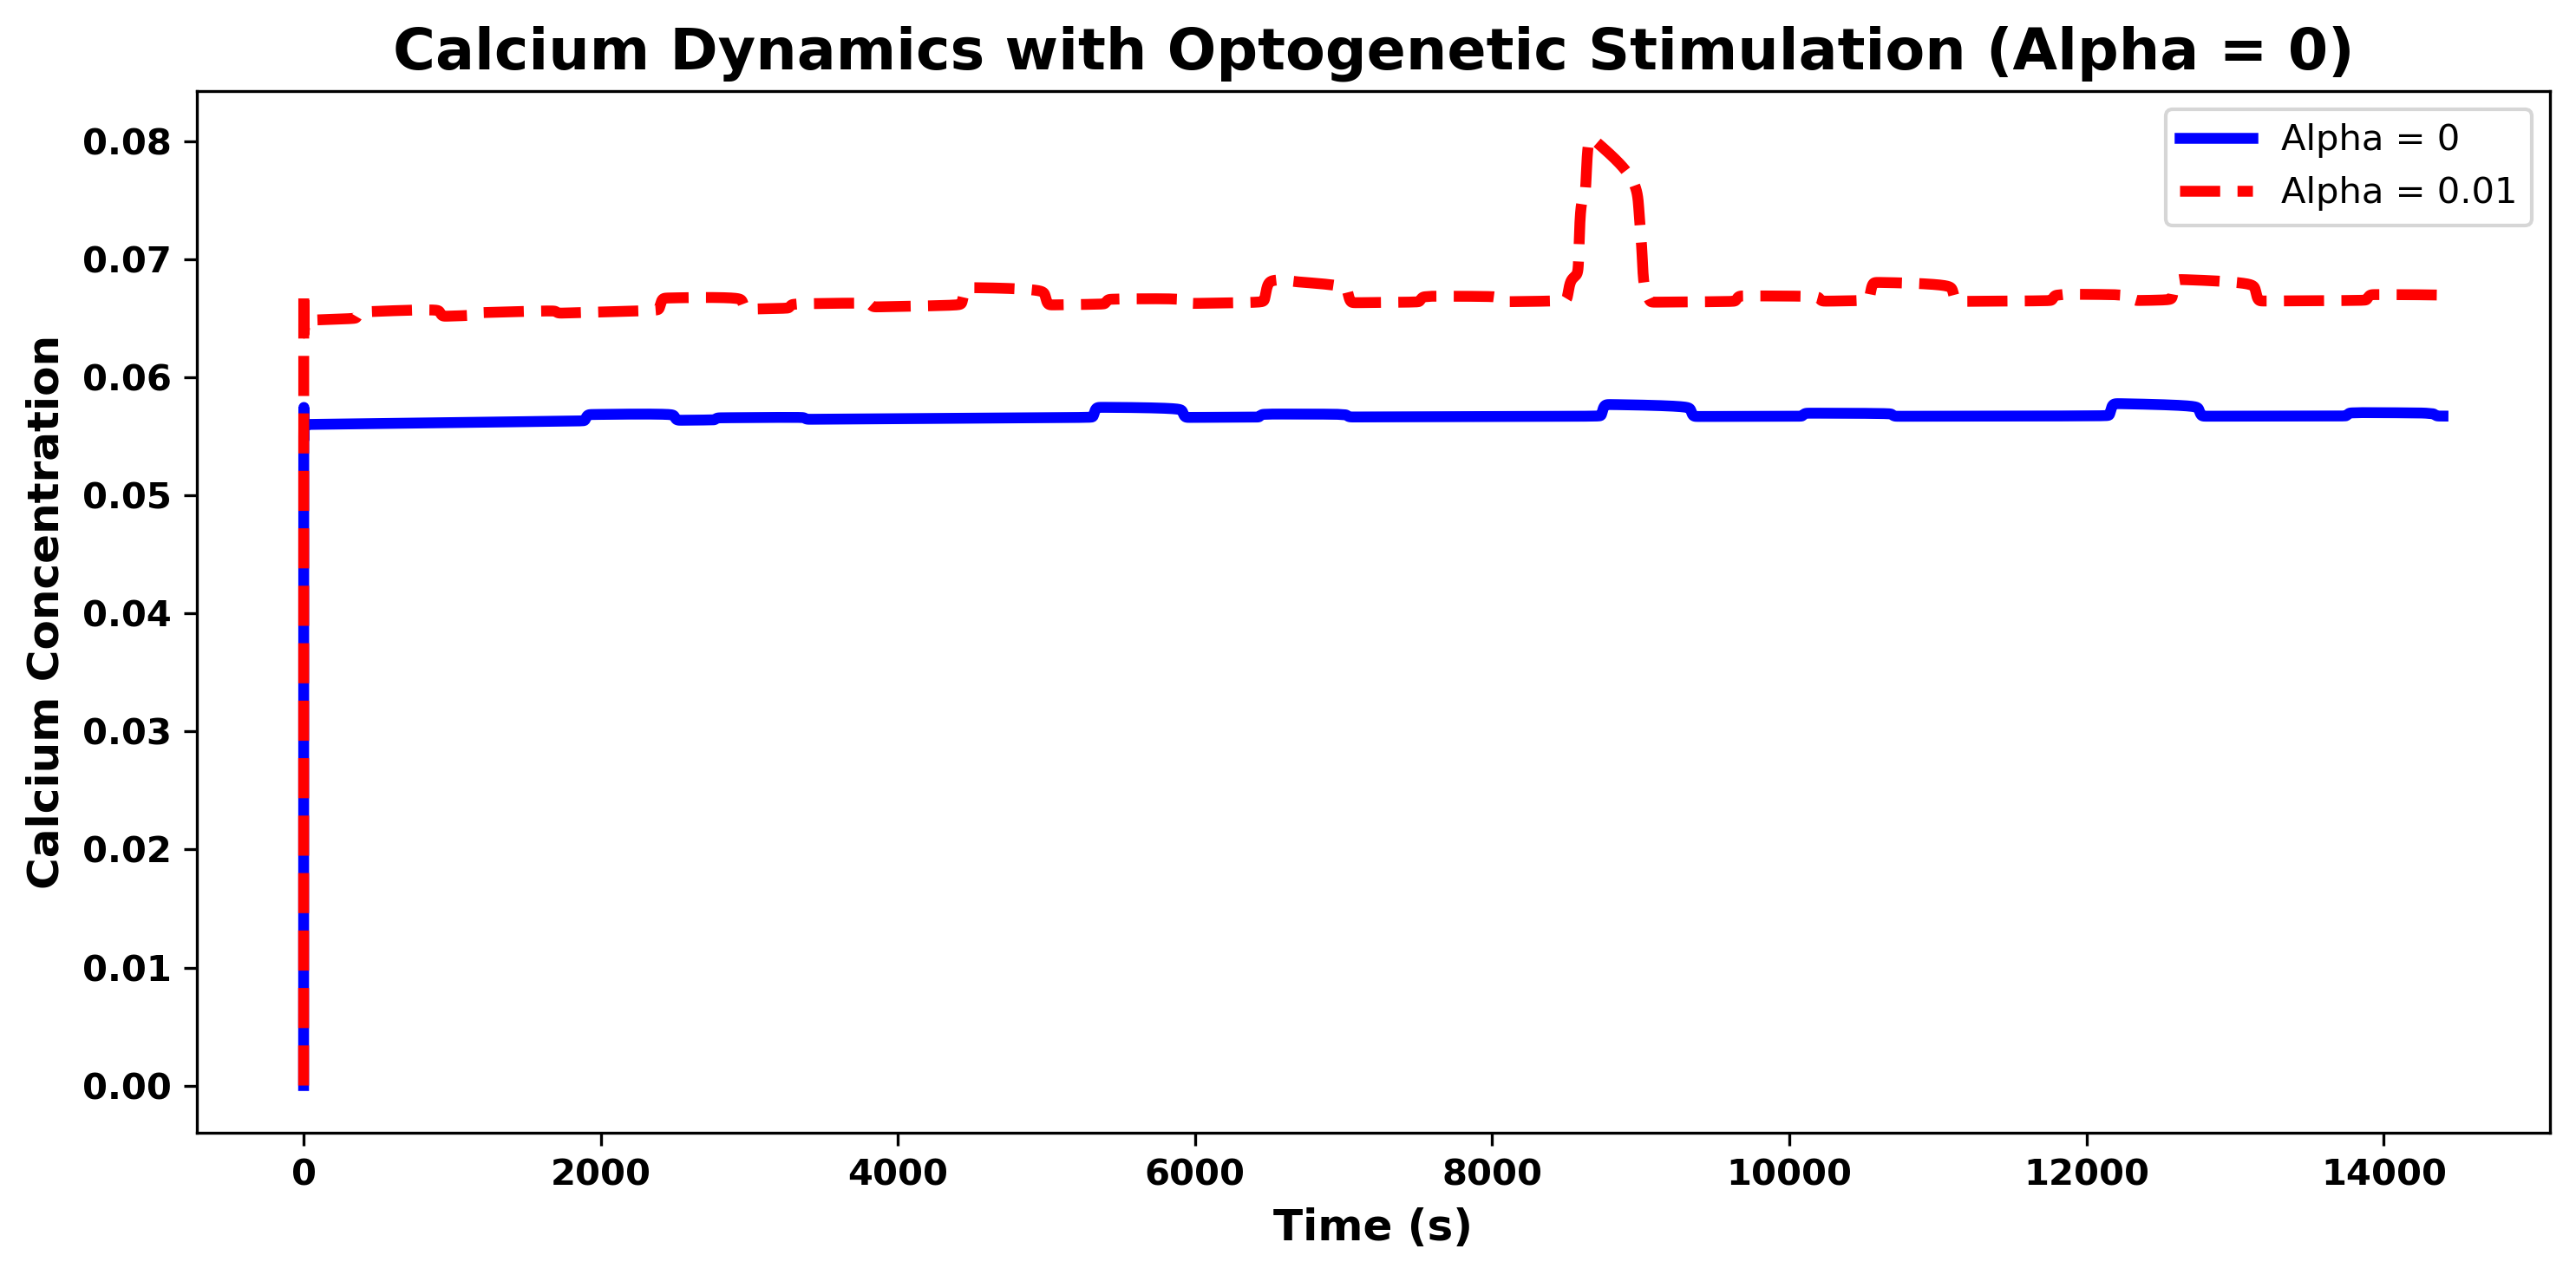

In [71]:
# Retrieve the simulation object for alpha = 0
alpha_0_simulation = simulations['Spikes'][0]

# Plot calcium dynamics for alpha = 0
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Plot calcium concentration over time
ax.plot(alpha_0_simulation.disc_dynamics[cell_index, 0, :].T, color='blue', label='Alpha = 0', linewidth=3)
# Plot calcium concentration for alpha = 0.01
ax.plot(p_Spikes_alpha_001.disc_dynamics[cell_index, 0, :].T, color='red', linestyle='--', label='Alpha = 0.01', linewidth=3)

# Add title and labels
ax.set_title('Calcium Dynamics with Optogenetic Stimulation (Alpha = 0)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Calcium Concentration', fontsize=12, fontweight='bold')

# Make x and y ticks bold
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize(10)

# Add legend
ax.legend(fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()